In [17]:
#!pip install langchain langgraph langsmith langchain_groq langchain_community arxiv wikipedia

In [18]:
from typing import Annotated  # to maintain State in state class
from typing_extensions import TypedDict

In [19]:
#External Tools
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper  #Arxiv is for Research paper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun  # this will be responsible for running



In [20]:
#defining Arxiv
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=300)
arxiv_tool=ArxivQueryRun(api_wrapper=arxiv_wrapper)

#defining Wikipedia
api_wrapper=WikipediaAPIWrapper(top_k_results=2,doc_content_chars_max=300)
wiki_tool=WikipediaQueryRun(api_wrapper=api_wrapper)

In [21]:

wiki_tool.invoke("who is Sharukh Khan")
tools=[wiki_tool]

In [22]:
arxiv_tool.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with "

In [23]:
from langgraph.graph.message import add_messages  

class State(TypedDict):
    messages:Annotated[list,add_messages]  #we use annoted and the add_mesaage library from Langgraph

In [24]:
# Now including the chat bot
from langgraph.graph import START,END,StateGraph

#building graph
graph_builder=StateGraph(State) #it is going to maintain different states in msg


In [25]:
from langchain_groq import ChatGroq
#declaring the Chat Bot Groq

api_grok="asdfgh"

llm=ChatGroq(groq_api_key=api_grok,model_name="gemma2-9b-it")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x1688cff50>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x1688cdf10>, model_name='gemma2-9b-it', model_kwargs={}, groq_api_key=SecretStr('**********'))

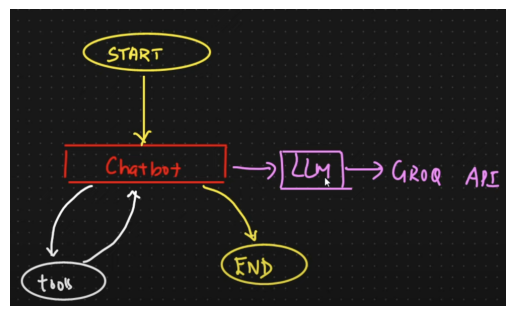

In [26]:
#!pip install matplotlib # This is out of Topic just to Display the Flow image is used can ignore
from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

img=mpimg.imread("/Users/arunkumar/Desktop/Flow.png")

plt.imshow(img)
plt.axis("off")
plt.show()

In [32]:
llm_with_tool=llm.bind_tools(tools=tools) #binding the LLM with the Tool

def chatbot(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}


In [28]:
from langgraph.prebuilt import ToolNode,tools_condition

try:
    graph_builder.add_node("chatbot",chatbot)   # defining what is what
    graph_builder.add_edge(START,"chatbot")      #here the actual graph takes place from start to chatbot
    
    tool_connect=ToolNode(tools=tools)
    graph_builder.add_node("tools",tool_connect)  # defining what is what

    # we need to add conditions for Bi directional edges from chatbot to tools
    graph_builder.add_conditional_edges(
         "chatbot",
         tools_condition
    )

    # From tools again it shopuld go the chatbot for that we add like below from tools to chatbot
    graph_builder.add_edge("tools","chatbot")
    graph_builder.add_edge("chatbot",END)
except ValueError as e:
    print(e)

In [29]:
graph=graph_builder.compile()

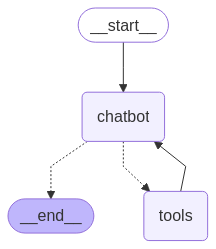

In [30]:
from IPython.display import Image,display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [40]:
user_input="Open AI"

events=graph.stream(
    {"messages":[("user",user_input)]},stream_mode="values"
)

for event in events:
    #event["messages"][-1].prity_print()
    #print(event["messages"])

    for msg in event["messages"]:
        role=msg.__class__.__name__.replace("Message","").upper()
        print(f"{role} : {msg.content}")


HUMAN : Open AI
HUMAN : Open AI
AI : 
HUMAN : Open AI
AI : 
TOOL : Page: History of artificial intelligence
Summary: The history of artificial intelligence (AI) began in antiquity, with myths, stories, and rumors of artificial beings endowed with intelligence or consciousness by master craftsmen. The study of logic and formal reasoning from antiquity to the present
HUMAN : Open AI
AI : 
TOOL : Page: History of artificial intelligence
Summary: The history of artificial intelligence (AI) began in antiquity, with myths, stories, and rumors of artificial beings endowed with intelligence or consciousness by master craftsmen. The study of logic and formal reasoning from antiquity to the present
AI : The history of artificial intelligence dates back to antiquity.  There are many myths, stories, and rumors about artificial beings endowed with intelligence.  The study of logic and formal reasoning has also contributed to the development of AI. 



